# Feature engineering
This notebook tries to improve the features used to train and predict.

### Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from time import time
from glob import glob
import pickle

from plots_fabi import *

# import models
# Add functions path
sys.path.append('../../Functions')

ModuleNotFoundError: No module named 'tensorflow_hub'

In [42]:
# TfidfVectorizer generates bag of words
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.svm import LinearSVC

### Load dataset

In [43]:
from datasets import load_stratified_dataset
from sklearn.model_selection import train_test_split
df = load_stratified_dataset(path='../../Datasets/dataset_categories/dataset_categories_train.csv', labels='category', samples_per_label=1000, random_seed=42)

***
# Word Importances
Calculate the word importances using naive bayes. (For more detail look in notebook word_analysis)

In [46]:
df_full = load_stratified_dataset(path='../../Datasets/dataset_categories/dataset_categories_train.csv', labels='category', samples_per_label=1000000, random_seed=42)

Smallest sample size in dataset is 12026 samples!


In [47]:
from word_importances import word_importances
word_imp = word_importances(df_full)

### Use word importances directly as features
Instead of using word embeddings or bag of words, use the word importances as features.

In [48]:
# Take full dataset
X_train, X_test, y_train, y_test = train_test_split(df.text_lem, df.category, random_state=42)

In [49]:
from word_embeddings.vectorizer import ImportanceVectorizer
# Just a class that can output vocabulary, vectors and the size of vectors.
class random_class():
    def __init__(self, vocab, vectors):
        self.vocab = np.array(vocab)
        self.vectors = vectors
        self.vector_size = vectors.shape[1]
    def __getitem__(self, word):
        return self.vectors[np.where(word_vectors.vocab==word)[0][0]]

In [50]:
with open('word_embeddings/.feature_importance_vectors.pickle', 'rb') as file:
    results = pickle.load(file)
vocab_sizes, test_acc, train_acc = results

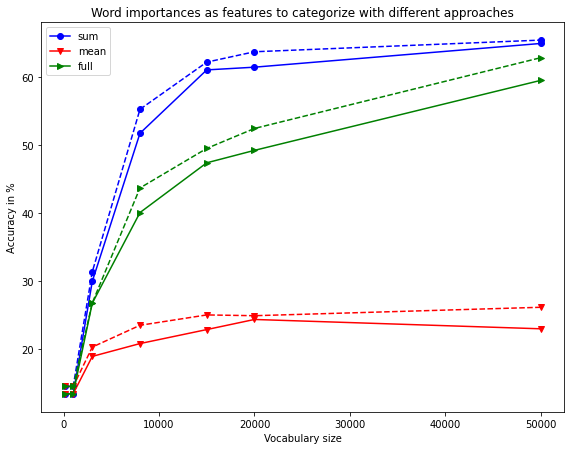

In [52]:
few_points_line_plot(vocab_sizes, test_acc, y2=train_acc, title='Word importances as features to categorize with different approaches', xlabel='Vocabulary size', ylabel='Accuracy in %')

Best result is achieved by taking the sum of probabilities for all words in each category. This one can be improved by more vocabulary of up to 25000 words, but still only reaches an accuracy of over 60%. No need to further test this.

***
# TF-IDF
Check if tfidf can be improved.

In [12]:
# sublinear_tf: use logarithmic form for frequency
# min_df: minimum numbers of documents a word must be present to keep it
# ngram_range: number of ngrams to use
# stopwords: remove all common pronouns in given language

### N-grams, min_df

In [44]:
def tfidf_(text, category, ngram=(1,2), min_df=5):
    
    X_train, X_test, y_train, y_test = train_test_split(text, category, random_state=42)
    
    # sublinear_tf: use logarithmic form for frequency
    # min_df: minimum numbers of documents a word must be present to keep it
    # ngram_range: number of ngrams to use
    # stopwords: remove all common pronouns in given language

    tfidf = TfidfVectorizer(sublinear_tf=True, min_df=min_df, norm='l2', encoding='latin-1',
                            ngram_range=ngram, stop_words='english')

    X_train_tfidf = tfidf.fit_transform(X_train)
    X_test_tfidf = tfidf.transform(X_test)
    
    return X_train_tfidf, X_test_tfidf, y_train, y_test

In [45]:
ngrams = [(1,2), (1,3), (2,2), (2,3)]
min_df = [5, 50, 100]
clf = LinearSVC(random_state=42, dual=False, max_iter=10000)
for ngram in ngrams:
    for min_d in min_df:
        X_train, X_test, y_train, y_test = tfidf_(df.text, df.category, ngram, min_d)
        clf.fit(X_train, y_train)
        result = (clf.score(X_train, y_train), clf.score(X_test, y_test))
        print('ngrams = {},{}, min_df = {: <5}: {:.2f}, {:.2f}'.format(ngram[0], ngram[1], min_d, result[0], result[1]))

ngrams = 1,2, min_df = 5    : 1.00, 0.74
ngrams = 1,2, min_df = 50   : 0.98, 0.71
ngrams = 1,2, min_df = 100  : 0.94, 0.68
ngrams = 1,3, min_df = 5    : 1.00, 0.74
ngrams = 1,3, min_df = 50   : 0.98, 0.71
ngrams = 1,3, min_df = 100  : 0.94, 0.68
ngrams = 2,2, min_df = 5    : 0.99, 0.68
ngrams = 2,2, min_df = 50   : 0.56, 0.49
ngrams = 2,2, min_df = 100  : 0.37, 0.36
ngrams = 2,3, min_df = 5    : 0.99, 0.68
ngrams = 2,3, min_df = 50   : 0.56, 0.49
ngrams = 2,3, min_df = 100  : 0.37, 0.36


***
Best accuracy for min_df of 5. ngrams of 1,2 or 1,3.
***

### Change max features

In [13]:
clf = LinearSVC(random_state=42, dual=False, max_iter=10000)
X_train, X_test, y_train, y_test = train_test_split(df.text_lem, df.category, random_state=42)

In [14]:
for m in [9000, 10000, 11000, None]:
    tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='latin-1',
                        ngram_range=(1,2), stop_words='english', max_features=m)

    X_train_tfidf = tfidf.fit_transform(X_train)
    X_test_tfidf = tfidf.transform(X_test)
    
    clf.fit(X_train_tfidf, y_train)
    print(m, 'Training accuracy: {:.2f}%;  Test accuracy: {:.2f}%'.format(clf.score(X_train_tfidf, y_train)*100, clf.score(X_test_tfidf, y_test)*100))
    

9000 Training accuracy: 99.09%;  Test accuracy: 72.51%
10000 Training accuracy: 99.12%;  Test accuracy: 72.86%
11000 Training accuracy: 99.22%;  Test accuracy: 72.86%
None Training accuracy: 99.50%;  Test accuracy: 73.37%


***
Reducing the feature size does not seem to improve test accuracy. Keep highest feature size by None.
***

### Test different vocabularies

In [53]:
# Take full dataset
X_train, X_test, y_train, y_test = train_test_split(df_full.text_lem, df_full.category, random_state=42)

In [55]:
# Loop over different vocabulary sizes
train_acc = []
test_acc = []
vocab_sizes = []

for vocab_size in [100, 500, 1000, 3000, 8000, 12000, 15000, 20000]:
    # Get vocabulary
    vocabulary = set()
    for category in word_imp.columns:
        vocabulary.update(word_imp[category].index[:vocab_size])
    vocabulary = list(vocabulary)
    
    # Create tfidf transformer
    tfidf = TfidfVectorizer(sublinear_tf=True, min_df=1, norm='l2', encoding='latin-1',
                        ngram_range=(1,2), stop_words='english', vocabulary=vocabulary)
    
    X_train_tfidf = tfidf.fit_transform(X_train)
    X_test_tfidf = tfidf.transform(X_test)
    
    clf.fit(X_train_tfidf, y_train)
    vocab_sizes.append(vocab_size)
    train_acc.append(clf.score(X_train_tfidf, y_train)*100)
    test_acc.append(clf.score(X_test_tfidf, y_test)*100)

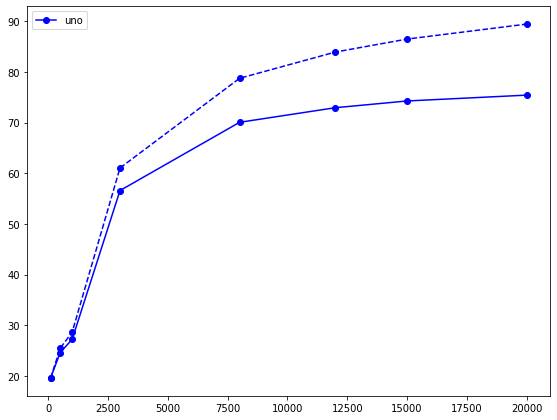

In [56]:
few_points_line_plot(vocab_sizes, {'uno': test_acc}, y2={'uno': train_acc})

***
Higher Vocab sizes improve train as well as test sizes. But test size stops increasing after 20000 vocabels, set limit at 40000

***
# Embeddings

### Word embedding

In [19]:
from word_embeddings.vectorizer import EmbeddingVectorizer

In [20]:
X_train, X_test, y_train, y_test = train_test_split(df.text_lem, df.category, random_state=42)

In [21]:
def lin_svc(word_vectors, method, vocab_count):
    clf = LinearSVC(random_state=42, dual=False, max_iter=10000)

    train_start = time()
    clf.fit(X_train_vec, y_train)
    train_time = time() - train_start

    pred_start = time()
    test_score = clf.score(X_test_vec, y_test) * 100
    train_score = clf.score(X_train_vec, y_train) * 100
    pred_time = time() - pred_start

    return {
        'word_vectors': word_vectors,
        'method': method,
        'vocab_count': vocab_count,
        'train_acc': train_score,
        'test_acc': test_score,
        'train_time': train_time,
        'pred_time': pred_time
    }

In [22]:
with open('word_embeddings/.word_embeddings_results_broad.pickle', 'rb') as file:
    results = pickle.load(file)

In [23]:
# Add vocab size and emb dim to dictionaries
for r in results:
    r['vocab_size'] = int(r['word_vectors'].split('voc_')[1].replace('.word_vectors', '').split('_dim_')[0])
    r['emb_dim'] = int(r['word_vectors'].split('voc_')[1].replace('.word_vectors', '').split('_dim_')[1])

#### Plots

In [24]:
def get_train_test(emb_dim, method, vocab_count, name):
    
    x = [r['vocab_size'] for r in results if r['emb_dim'] == emb_dim and r['method'] == method and r['vocab_count'] == vocab_count]
    train = [r['train_acc'] for r in results if r['emb_dim'] == emb_dim and r['method'] == method and r['vocab_count'] == vocab_count]
    test = [r['test_acc'] for r in results if r['emb_dim'] == emb_dim and r['method'] == method and r['vocab_count'] == vocab_count]
    
    # Sort values
    x, train, test = zip(*sorted(zip(x, train, test)))
    
    y[name] = test
    y2[name] = train

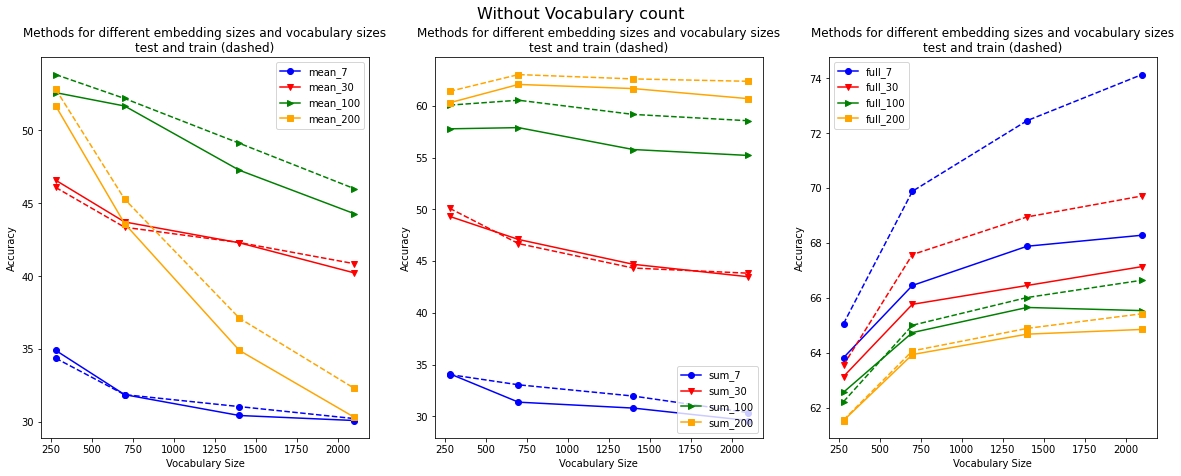

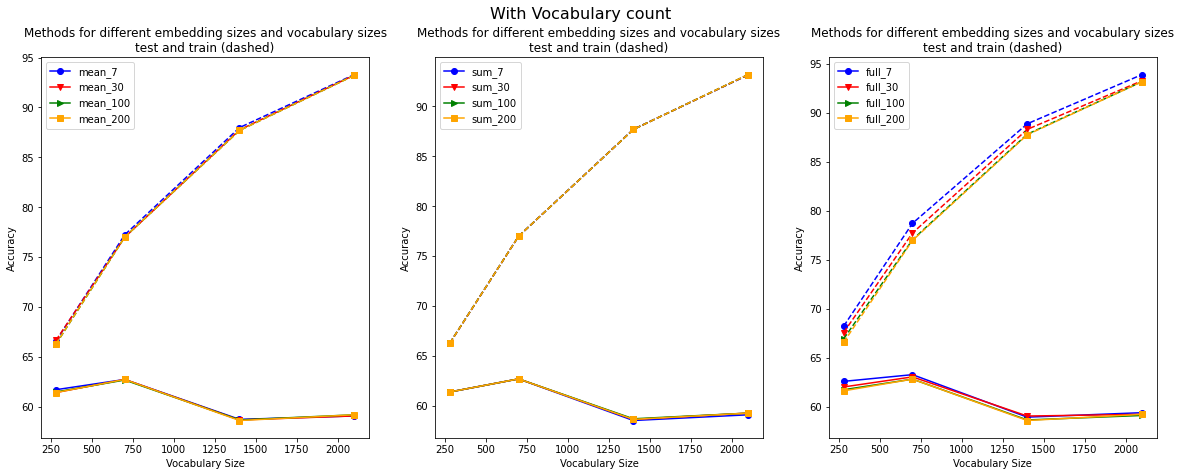

In [25]:
fig, ax = plt.subplots(1,3, figsize=(20,7))
fig.suptitle('Without Vocabulary count', fontsize=16)
count = 0
for method in ['mean', 'sum', 'full']:
    # Vocabulary count
    x = sorted([r['vocab_size'] for r in results if r['emb_dim'] == 7 and r['method'] == 'mean' and r['vocab_count'] == False])
    y = {}
    y2 = {}

    get_train_test(7, method, False, method + '_7')
    get_train_test(30, method, False, method + '_30')
    get_train_test(100, method, False, method + '_100')
    get_train_test(200, method, False, method + '_200')

    few_points_line_plot(x, y, y2=y2, ax=ax[count],
                         title='Methods for different embedding sizes and vocabulary sizes\ntest and train (dashed)',
                         xlabel='Vocabulary Size', 
                         ylabel='Accuracy')
    count += 1
    
plt.show()

fig, ax = plt.subplots(1,3, figsize=(20,7))
fig.suptitle('With Vocabulary count', fontsize=16)
count = 0
for method in ['mean', 'sum', 'full']:
    # Vocabulary count
    x = sorted([r['vocab_size'] for r in results if r['emb_dim'] == 7 and r['method'] == 'mean' and r['vocab_count'] == True])
    y = {}
    y2 = {}
    
    for emb in [7,30,100,200]:
        get_train_test(emb, method, True, method + '_' + str(emb))

    few_points_line_plot(x, y, y2=y2, ax=ax[count],
                         title='Methods for different embedding sizes and vocabulary sizes\ntest and train (dashed)',
                         xlabel='Vocabulary Size', 
                         ylabel='Accuracy')
    count += 1

* Vocabulary Count leads to strong variance
* method full seems to be better for low embedding and high vocabulary size
* method sum is best for high embedding size, and best for medium sized vocabulary
* method mean increases with lower vocabulary size, mostly for high embedding

### Test again for different options
#### Mean

In [26]:
# Loop over all word vectors
results = []
count = 1
total = int(len(glob('word_embeddings/word2vec/mean_test/*')))
start = time()
vocab_count=False
for word_vectors in glob('word_embeddings/word2vec/mean_test/*'):
    for method in ['mean']:
            #print(word_vectors, method, vocab_count)
            emb_vec = EmbeddingVectorizer(method=method, word_vectors=word_vectors)
            X_train_vec = emb_vec.transform(X_train)
            X_test_vec = emb_vec.transform(X_test)
            results.append(lin_svc(word_vectors, method, vocab_count))
            print('{:.2f}%'.format(count/total*100), end='\r')
            count+=1
print('finished in {:.2f}m'.format((time()-start)/60))

finished in 0.64m


In [27]:
with open('word_embeddings/.word_embeddings_results_mean.pickle', 'wb') as file:
    pickle.dump(results, file, protocol=pickle.HIGHEST_PROTOCOL)

In [28]:
with open('word_embeddings/.word_embeddings_results_mean.pickle', 'rb') as file:
    results = pickle.load(file)

In [29]:
# Add vocab size and emb dim to dictionaries
for r in results:
    r['vocab_size'] = int(r['word_vectors'].split('voc_')[1].replace('.word_vectors', '').split('_dim_')[0])
    r['emb_dim'] = int(r['word_vectors'].split('voc_')[1].replace('.word_vectors', '').split('_dim_')[1])

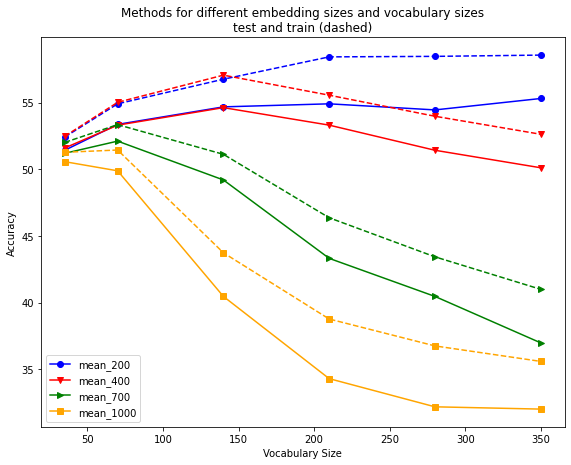

In [30]:
method='mean'

# Vocabulary count
x = sorted([r['vocab_size'] for r in results if r['emb_dim'] == 200 and r['vocab_count'] == False])
y = {}
y2 = {}

for emb in [200,400,700,1000]:
    get_train_test(emb, method, False, method + '_' + str(emb))

few_points_line_plot(x, y, y2=y2,
                     title='Methods for different embedding sizes and vocabulary sizes\ntest and train (dashed)',
                     xlabel='Vocabulary Size', 
                     ylabel='Accuracy')

#### Sum

In [31]:
# Loop over all word vectors
results = []
count = 1
total = int(len(glob('word_embeddings/word2vec/sum_test/*')))
start = time()
vocab_count=False
for word_vectors in glob('word_embeddings/word2vec/sum_test/*'):
    for method in ['sum']:
            #print(word_vectors, method, vocab_count)
            emb_vec = EmbeddingVectorizer(method=method, word_vectors=word_vectors)
            X_train_vec = emb_vec.transform(X_train)
            X_test_vec = emb_vec.transform(X_test)
            results.append(lin_svc(word_vectors, method, vocab_count))
            print('{:.2f}%'.format(count/total*100), end='\r')
            count+=1
print('finished in {:.2f}m'.format((time()-start)/60))

finished in 0.23m


In [32]:
with open('word_embeddings/.word_embeddings_results_sum.pickle', 'wb') as file:
    pickle.dump(results, file, protocol=pickle.HIGHEST_PROTOCOL)

In [33]:
with open('word_embeddings/.word_embeddings_results_sum.pickle', 'rb') as file:
    results = pickle.load(file)

In [34]:
# Add vocab size and emb dim to dictionaries
for r in results:
    r['vocab_size'] = int(r['word_vectors'].split('voc_')[1].replace('.word_vectors', '').split('_dim_')[0])
    r['emb_dim'] = int(r['word_vectors'].split('voc_')[1].replace('.word_vectors', '').split('_dim_')[1])

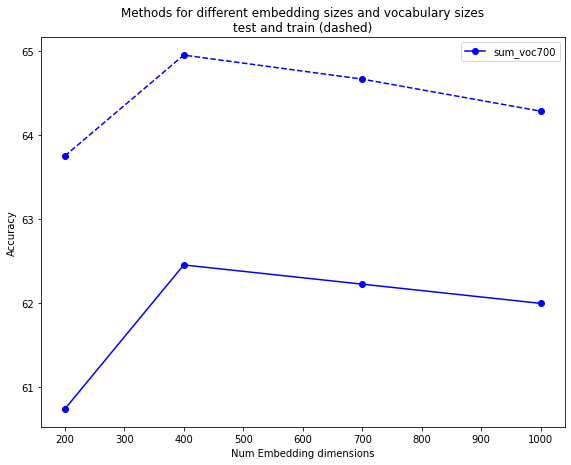

In [35]:
method='sum'

# Vocabulary count
x = [r['emb_dim'] for r in results if r['vocab_count'] == False]
ytr = [r['train_acc'] for r in results if r['vocab_count'] == False]
yte = [r['test_acc'] for r in results if r['vocab_count'] == False]

x, ytr, yte = zip(*sorted(zip(x, ytr, yte)))
y = {'sum_voc700': yte}
y2 = {'sum_voc700': ytr}

few_points_line_plot(x, y, y2=y2,
                     title='Methods for different embedding sizes and vocabulary sizes\ntest and train (dashed)',
                     xlabel='Num Embedding dimensions', 
                     ylabel='Accuracy')

***
## Use vocabulary selected by word2vec

In [36]:
from gensim.test.utils import common_texts
from gensim.models import Word2Vec
import gensim

#### Create, fit and save embedding vectors

In [37]:
# Create word vectors
model = Word2Vec(size=100, max_vocab_size=100000, window=5, min_count=1, workers=1)
# Set vocabulary
model.build_vocab(sentences=df_full.text_lem.values)
# Train model on lemmatized articles
model.train(df_full.text_lem, total_examples=1, epochs=model.epochs)
# Create word vectors
word_vectors = model.wv
# Save Word vectors
word_vectors.save('word_embeddings/word2vec/random_vocab.word_vectors')
# Get sizes
print('Embedding vectors represent {} vocabularies using {} embedding dimensions!'.format(len(word_vectors.vocab), word_vectors.vector_size))

Embedding vectors represent 794 vocabularies using 100 embedding dimensions!


In [38]:
results = []
for method in ['sum', 'mean', 'full']:
    # Create transformer
    emb_vec = EmbeddingVectorizer(word_vectors='word_embeddings/word2vec/random_vocab.word_vectors', method=method)
    X_train_vec = emb_vec.transform(X_train)
    X_test_vec = emb_vec.transform(X_test)
    results.append(lin_svc(word_vectors, method, 794))

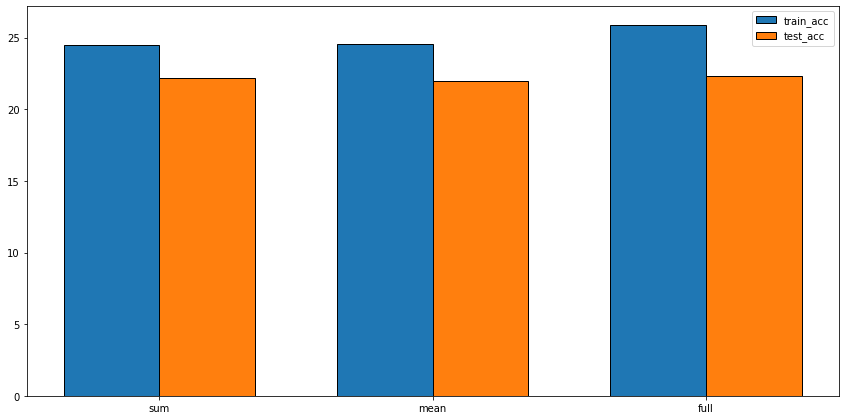

In [39]:
x = [i['method'] for i in results]
y1 = [i['train_acc'] for i in results]
y2 = [i['test_acc'] for i in results]
y = [y1,y2]
bar_adjacent_labels(x, y)